In [1]:
import ipywidgets as widgets

topo_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='topo path:',
    disabled=False
)


vtk_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='vtk path',
    disabled=False
)

display(topo_path)
display(vtk_path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='topo path:', placeho…

Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='vtk path', placehold…

In [2]:
%matplotlib inline
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from scipy.optimize import minimize
from scipy.spatial import distance
import ipyvolume as ipv
import numpy as np
from skimage import io, filters
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy.ma as ma

pt_cloud_cyl = np.load(topo_path.value)

reader = vtk.vtkXMLPolyDataReader()
reader.SetFileName(vtk_path.value)
reader.Update()

In [3]:
import numpy.ma as ma

def interpolate(pt_cloud,x,y):
    triang = tri.Triangulation(pt_cloud[:,1], pt_cloud[:,2])
    interpolator = tri.LinearTriInterpolator(triang, pt_cloud[:,0])
    return interpolator(Xi, Yi)    

norm_pt_cloud_na = np.copy(pt_cloud_cyl)
norm_pt_cloud_na[:,0] = norm_pt_cloud_na[:,0] - 5.8/2

z_res = 200
theta_res = 300
r_res = 5

r_delta_max = np.max(norm_pt_cloud_na[:,0])
r_delta_min = np.min(norm_pt_cloud_na[:,0])
zz = np.linspace(-1.00,1.00,z_res)
Xi, Yi = np.meshgrid(np.linspace(0,2*np.pi,theta_res),zz)
r = interpolate(norm_pt_cloud_na,Xi, Yi)


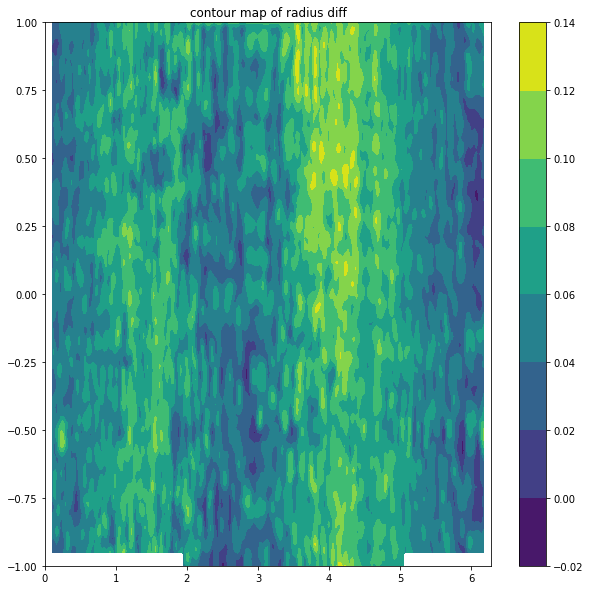

In [4]:
from skimage.filters import gaussian
smoothed = gaussian(r,sigma = 1)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title('contour map of radius diff')
cf = ax.contourf(Xi, Yi,smoothed)
fig.colorbar(cf)
plt.show()

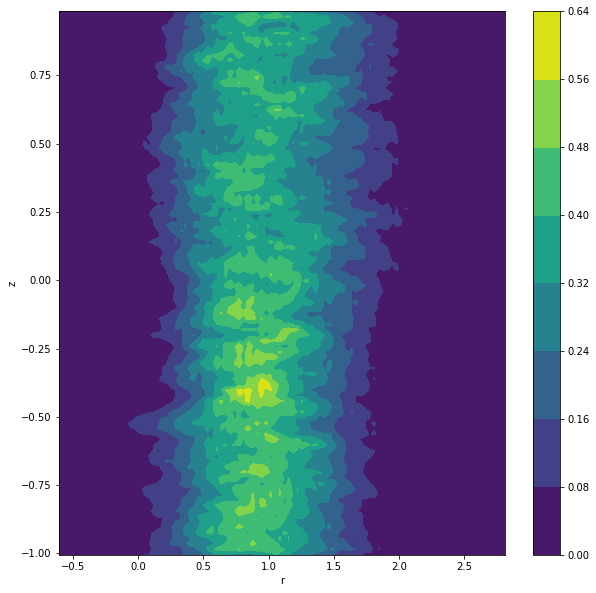

In [39]:
fig, ax = plt.subplots(figsize=(10,10))

mean = np.mean(norm_pt_cloud_na[:,0])

H_s, x_edges,y_edges = np.histogram2d(norm_pt_cloud_na[:,0]/mean,norm_pt_cloud_na[:,2], bins = 100, normed = True)
x_grid, y_grid = np.meshgrid(x_edges[0:-1],y_edges[0:-1])
c = ax.contourf(x_grid, y_grid, H_s.T)
ax.set_xlabel('r')
ax.set_ylabel('z')
fig.colorbar(c)
plt.show()

In [6]:
pore_net = dsa.WrapDataObject(reader.GetOutput())

equiv_dia = pore_net.PointData['network | net_01 | properties | pore.equivalent_diameter']
pt_cloud_pt = pore_net.GetPoints()

ipv.quickscatter(pt_cloud_pt[:,0], pt_cloud_pt[:,1], pt_cloud_pt[:,2], size=equiv_dia/10, marker="sphere")
ipv.show()

C:\Users\inst\.conda\envs\machine_learning\lib\site-packages\traittypes\traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


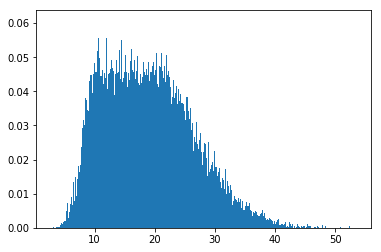

In [7]:
fig, ax = plt.subplots()
bin, edge, patch = ax.hist(equiv_dia,1000,density = True)
plt.show()

In [8]:
print("D90: {}".format(np.percentile(equiv_dia,90)))

D90: 28.825642942651694


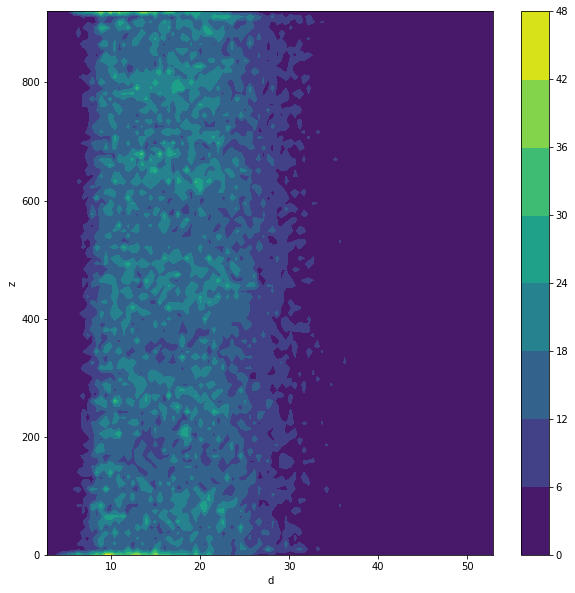

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
H_p, x_edges,y_edges = np.histogram2d(equiv_dia,pt_cloud_pt[:,2], bins = 100)
x_grid, y_grid = np.meshgrid(x_edges[0:-1],y_edges[0:-1])
c = ax.contourf(x_grid, y_grid, H_p.T)
ax.set_xlabel('d')
ax.set_ylabel('z')
fig.colorbar(c)
plt.show()

In [10]:
volume_p = pore_net.PointData['network | net_01 | properties | pore.volume']

bin_i_x = np.digitize(equiv_dia, x_edges)
bin_i_y = np.digitize(pt_cloud_pt[:,2], y_edges)

In [11]:
heat_map = np.zeros(H_p.shape)

for i in range(H_p.shape[0]):
    for j in range(H_p.shape[1]):
        heat_map[i,j] = np.sum(volume_p[np.logical_and(bin_i_x == i, bin_i_y == j)])

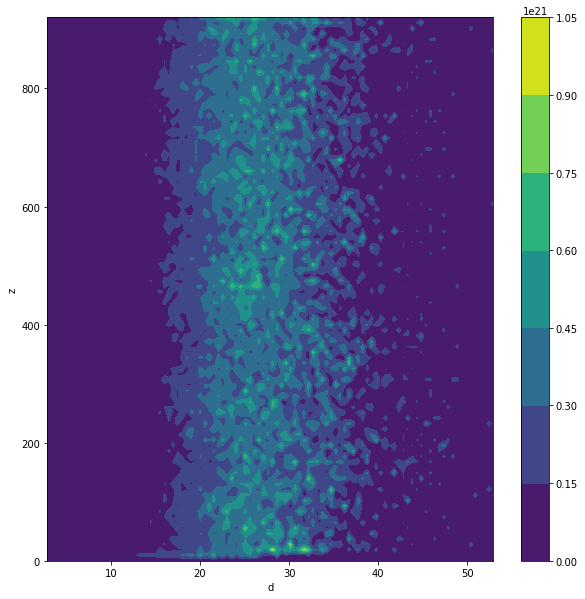

In [12]:
vol = 5.8e-6**2*np.pi/4*10e-6

fig, ax = plt.subplots(figsize=(10,10))
x_grid, y_grid = np.meshgrid(x_edges[0:-1],np.linspace(-1.0,1.0,100))
c = ax.contourf(x_grid, y_grid, heat_map.T/vol)
ax.set_xlabel('d')
ax.set_ylabel('z')
fig.colorbar(c)
plt.show()

In [40]:
from rpy2.robjects.packages import importr

ks = importr("ks")

In [41]:
rescaled_s = np.copy(norm_pt_cloud_na[:,[0,2]])

rescaled_s[:,1] = rescaled_s[:,1] - np.min(rescaled_s[:,1])
rescaled_s[:,1] = rescaled_s[:,1]/np.max(rescaled_s[:,1])
rescaled_s[:,0] = rescaled_s[:,0]/np.mean(rescaled_s[:,0])

rescaled_p = np.vstack([equiv_dia,pt_cloud_pt[:,2]]).T
rescaled_p[:,0] = rescaled_p[:,0]/np.mean(rescaled_p[:,0])
rescaled_p[:,1] = rescaled_p[:,1] - np.min(rescaled_p[:,1])
rescaled_p[:,1] = rescaled_p[:,1]/np.max(rescaled_p[:,1])


In [42]:
from sklearn.utils.random import sample_without_replacement

n = int(rescaled_p.shape[0])
sample = sample_without_replacement(rescaled_p.shape[0],n,'auto')

In [ ]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

test = ks.kde_test(rescaled_s[sample],rescaled_p)

In [ ]:
print(test[2])